# 1. Get the data

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def extract_num(x):
    try:
        return float(re.findall(r'([\d.]+)', x.replace(' ', '').replace(',', '.'))[-1].replace(' ', ''))
    except:
        return np.inf

In [3]:
# Income tax brackets.
tax_brackets = pd.read_html('http://www.belastingschijven.be/', match='chijf', header=0)[-1]
tax_brackets.Inkomensschijf = tax_brackets.Inkomensschijf.map(extract_num)
tax_brackets['Tarief belasting'] = tax_brackets['Tarief belasting'].map(extract_num) / 100.
tax_brackets.at[len(tax_brackets) - 1, 'Inkomensschijf'] = np.inf
tax_brackets

,Belastingschijf,Inkomensschijf,Tarief belasting
0,Schijf 1,1.086000e+04,0.25
1,Schijf 2,1.247000e+04,0.30
2,Schijf 3,2.078000e+04,0.40
3,Schijf 4,3.808000e+04,0.45
4,Schijf 5,inf,0.50


In [4]:
# Expenses forfait brackets.
expenses_forfait = pd.read_html('http://www.belastingschijven.be/beroepskosten-kostenforfait/', match='chijf', header=0)[-1]
max_forfait = extract_num(expenses_forfait.iat[-1, 1])
expenses_forfait = expenses_forfait.iloc[:-1, :]
expenses_forfait.Inkomstenschijf = expenses_forfait.Inkomstenschijf.map(extract_num)
expenses_forfait.Kostenforfait = expenses_forfait.Kostenforfait.map(extract_num) / 100.
expenses_forfait.at[len(expenses_forfait) - 1, 'Inkomstenschijf'] = np.inf
expenses_forfait

,Inkomstenschijf,Kostenforfait
0,5.760000e+03,0.2935
1,1.138000e+04,0.1050
2,1.939000e+04,0.0800
3,inf,0.0300


In [5]:
# Marriage quotient transfers up to 30% of largest income to smallest one for legal cohabitants [1].
# Tax free sum applies to separate incomes and scales with the number of dependents [1].
# Social security tax depends on whether you are an employee or self-employed [2].
# VAPZ is a way to reduce taxable income for self-employeds.
# [1] http://www.boekhouder.be/tips-tricks/925-geindexeerde-bedragen-personenbelasting-aanslagjaar-2017.html
# [2] http://www.xerius.be/zelfstandigen/start-eigen-zaak/zelfstandige-versus-werknemer/
marriagequotient_rel_max = 0.3
marriagequotient_abs_max = 10290.0 
tax_free_sum_base = 7130.0
tax_free_sum_per_child = 1520.0
social_security_tax_employee = 0.1307
social_security_tax_selfemployed_rel = 0.215
social_security_tax_selfemployed_abs_min = 726.94 * 4
vapz_rel_max = 0.0817
vapz_abs_max = 3060.07

In [6]:
# Efficiency of extracting money from a company is determined by the corporate income tax and dividend tax.
# As soon as the income tax exceeds this magic number, we are better off extracting money from the company instead of paying a salary.
crisis_tax = 0.03
corporate_income_tax = 0.33 * (1. + crisis_tax)
dividend_tax = 0.27
profit_extraction_tax = (1. - corporate_income_tax) * (1 - dividend_tax)
profit_extraction_tax

0.48187299999999994

# 2. Simulate taxes

Includes:
- Expenses forfait
- Social security tax for employees and self-employeds
- Assumes full VAPZ exploitation
- Marriage quotient
- Dependents forfait
- Income tax
- Municipality tax

Caveats:
- Intentionally disregards pension saving incentives since only short-term benefits are clear.
- Disregards the "woonbonus" in the interest of simplicity.
- Does not take into account property tax since it is not based on income but on kadastral income.
- Tax free sum per child is only an approximation.

A good source for the simulation below is a tax form with comments by Test-Aankoop [1].

[1] https://www.test-aankoop.be/geld/belastingen/dossier/uw-aanslagbiljet-van-a-tot-z

In [7]:
def bracketed_value(brackets, rates, value):
    # Computes a bracketed value.
    orig_shape = value.shape
    brackets_lower = np.zeros_like(brackets)
    brackets_lower[1:] = brackets[:-1]
    brackets_upper = np.reshape(brackets, [1, -1])
    brackets_lower = np.reshape(brackets_lower, [1, -1])
    rates = np.reshape(rates, [1, -1])
    value = np.reshape(value, [-1, 1])
    matrix = np.maximum(brackets_lower, np.minimum(brackets_upper, np.reshape(value, [-1, 1])))
    matrix -= brackets_lower
    return np.reshape(np.sum(rates * matrix, axis=1), orig_shape)

def apply_expenses_forfait(gross_income):
    brackets = expenses_forfait.Inkomstenschijf.values
    rates = expenses_forfait.Kostenforfait.values
    forfait = bracketed_value(brackets, rates, gross_income)
    forfait = np.minimum(max_forfait, forfait)
    gross_income = gross_income - forfait
    return gross_income

def apply_social_security_tax(gross_income, is_selfemployed=False):
    if is_selfemployed:
        ss_tax = np.maximum(
            social_security_tax_selfemployed_abs_min,
            social_security_tax_selfemployed_rel * gross_income)
        vapz_capital = np.minimum(vapz_rel_max * gross_income, vapz_abs_max)
        vapz_profit = vapz_capital
        vapz_tax = (vapz_capital + vapz_profit) * (0.0355 + 0.02) + (vapz_capital * 0.8) * 0.05
        ss_tax += vapz_tax
        gross_taxable_income = np.maximum(0., gross_income - ss_tax - vapz_capital)
    else:
        ss_tax = social_security_tax_employee * gross_income
        gross_taxable_income = np.maximum(0., gross_income - ss_tax)
    return ss_tax, gross_taxable_income

def apply_marriage_quotient(gross_taxable_income_a, gross_taxable_income_b):
    total_income = gross_taxable_income_a + gross_taxable_income_b
    min_income = np.minimum(gross_taxable_income_a, gross_taxable_income_b)
    a_is_min = gross_taxable_income_a == min_income
    if static_parameters['legally_cohabiting']:
        delta = np.maximum(0., np.minimum(marriagequotient_rel_max * total_income - min_income, marriagequotient_abs_max))
        gross_taxable_income_a[a_is_min] += delta[a_is_min]
        gross_taxable_income_b[~a_is_min] += delta[~a_is_min]
        gross_taxable_income_a[~a_is_min] -= delta[~a_is_min]
        gross_taxable_income_b[a_is_min] -= delta[a_is_min]
    return gross_taxable_income_a, gross_taxable_income_b

def apply_dependents_forfait(gross_taxable_income):
    return np.maximum(0., gross_taxable_income - tax_free_sum_per_child * static_parameters['n_dependents'])

def apply_income_tax(gross_taxable_income):
    net_taxable_income = np.maximum(0., gross_taxable_income - tax_free_sum_base)
    brackets = tax_brackets.Inkomensschijf.values
    rates = tax_brackets['Tarief belasting'].values
    income_tax = bracketed_value(brackets, rates, net_taxable_income)
    return income_tax

def apply_municipality_tax(income_tax):
    municipality_tax = static_parameters['municipality_tax'] * income_tax
    return municipality_tax

def income_tax_legally_cohabiting(gross_income_a, gross_income_b):
    # First deduct expenses before applying any taxes.
    gross_income_a = apply_expenses_forfait(gross_income_a)
    gross_income_b = apply_expenses_forfait(gross_income_b)
    # Social security tax to obtain the gross taxable income.
    n_selfemployed = static_parameters['n_selfemployed']
    tax_a, gross_taxable_income_a = apply_social_security_tax(gross_income_a, is_selfemployed=n_selfemployed >= 1)
    tax_b, gross_taxable_income_b = apply_social_security_tax(gross_income_b, is_selfemployed=n_selfemployed >= 2)
    # The marriage quotient redistributes the incomes between a and b.
    if static_parameters['legally_cohabiting']:
        gross_taxable_income_a, gross_taxable_income_b = apply_marriage_quotient(gross_taxable_income_a, gross_taxable_income_b)
    # Subtract dependents from largest gross taxable income.
    a_is_min = gross_taxable_income_a == np.minimum(gross_taxable_income_a, gross_taxable_income_b)
    gross_taxable_income_a[~a_is_min] = apply_dependents_forfait(gross_taxable_income_a[~a_is_min])
    gross_taxable_income_b[a_is_min] = apply_dependents_forfait(gross_taxable_income_b[a_is_min])
    # Individual income tax.
    income_tax_a = apply_income_tax(gross_taxable_income_a)
    income_tax_b = apply_income_tax(gross_taxable_income_b)
    tax_a += income_tax_a
    tax_b += income_tax_b
    # Municipality tax.
    tax_a += apply_municipality_tax(income_tax_a)
    tax_b += apply_municipality_tax(income_tax_b)
    return tax_a, tax_b

class nf(float):
    def __repr__(self):
        return '%.1f' % (self.__float__(),)

def plot_tax_rate(X, Y, tax_rate, title):
    tax_rate_levels = np.arange(.10, .60, .02)
    plt.figure(figsize=(12, 6))
    cs = plt.contour(X, Y, 100. * tax_rate, levels=100. * tax_rate_levels, cmap='jet')
    plt.xlabel('gross income %s A (euro)' % ('self-employed' if static_parameters['n_selfemployed'] >= 1 else 'employee'))
    plt.ylabel('gross income %s B (euro)' % ('self-employed' if static_parameters['n_selfemployed'] >= 2 else 'employee'))
    plt.title(title)
    plt.grid(which='both')
    cs.levels = [nf(val) for val in cs.levels]
    plt.clabel(cs, cs.levels, inline=True, fmt='%r %%', fontsize=10);

# 3. Example situations

## 3.1 Situation: legally cohabiting self-employed + employee + no dependents

In [8]:
# Municipality tax is usually around 7% except for coastal cities [1].
# If you are part of the Brussels agglomeration, you should add another 1% on top of the municipality tax.
# [1] http://financien.belgium.be/nl/particulieren/belastingaangifte/gemeentebelasting
static_parameters = {
    'legally_cohabiting': True,
    'n_dependents': 0,
    'municipality_tax': 0.07,
    'n_selfemployed': 1
}

In [9]:
# Example taxes.
income_tax_legally_cohabiting(np.array([3e4]), np.array([0.]))

(array([ 7638.62651797]), array([ 0.]))

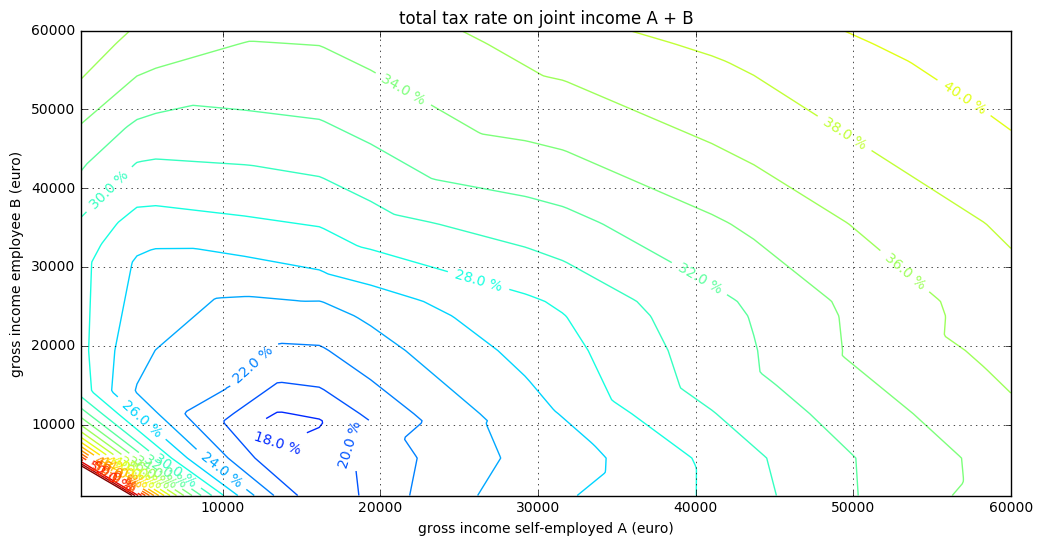

In [10]:
gross_income_a, gross_income_b = np.meshgrid(np.linspace(1e3, 6e4, 200), np.linspace(1e3, 6e4, 200))
tax_a, tax_b = income_tax_legally_cohabiting(gross_income_a, gross_income_b)
total_tax_rate = (tax_a + tax_b) / (gross_income_a + gross_income_b)
plot_tax_rate(gross_income_a, gross_income_b, total_tax_rate, 'total tax rate on joint income A + B')

## 3.2 Situation: legally cohabiting self-employed + employee + one dependent

In [11]:
static_parameters = {
    'legally_cohabiting': True,
    'n_dependents': 1,
    'municipality_tax': 0.07,
    'n_selfemployed': 1
}

In [12]:
# Example taxes.
income_tax_legally_cohabiting(np.array([3e4]), np.array([1e4]))

(array([ 8512.13939051]), array([ 1153.05105559]))

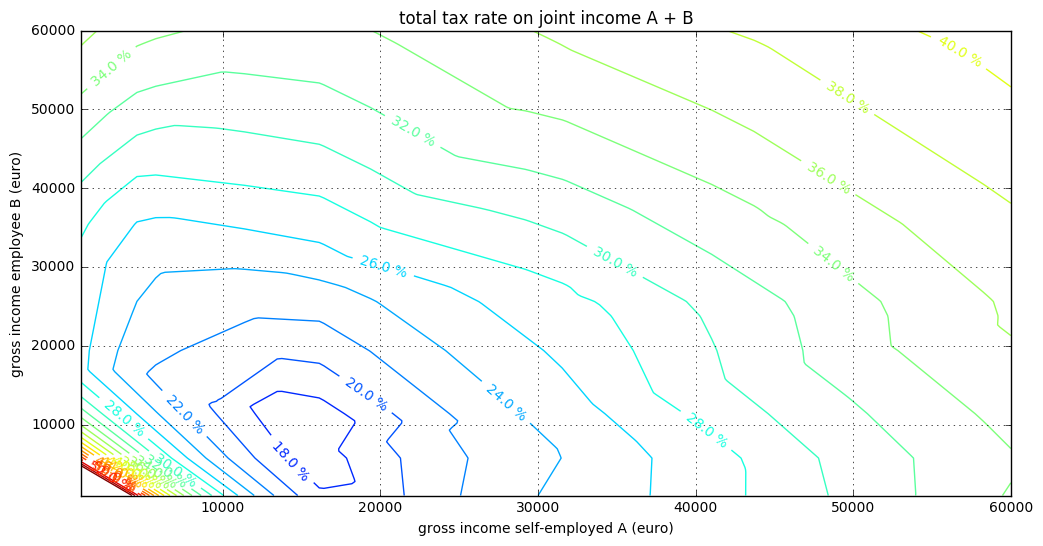

In [13]:
gross_income_a, gross_income_b = np.meshgrid(np.linspace(1e3, 6e4, 200), np.linspace(1e3, 6e4, 200))
tax_a, tax_b = income_tax_legally_cohabiting(gross_income_a, gross_income_b)
total_tax_rate = (tax_a + tax_b) / (gross_income_a + gross_income_b)
plot_tax_rate(gross_income_a, gross_income_b, total_tax_rate, 'total tax rate on joint income A + B')

## 3.3 Situation: legally cohabiting employee + employee + one dependent

In [14]:
static_parameters = {
    'legally_cohabiting': True,
    'n_dependents': 1,
    'municipality_tax': 0.07,
    'n_selfemployed': 0
}

In [15]:
# Example taxes.
income_tax_legally_cohabiting(np.array([3e4]), np.array([100.]))

(array([ 5551.12472177]), array([ 9.233955]))

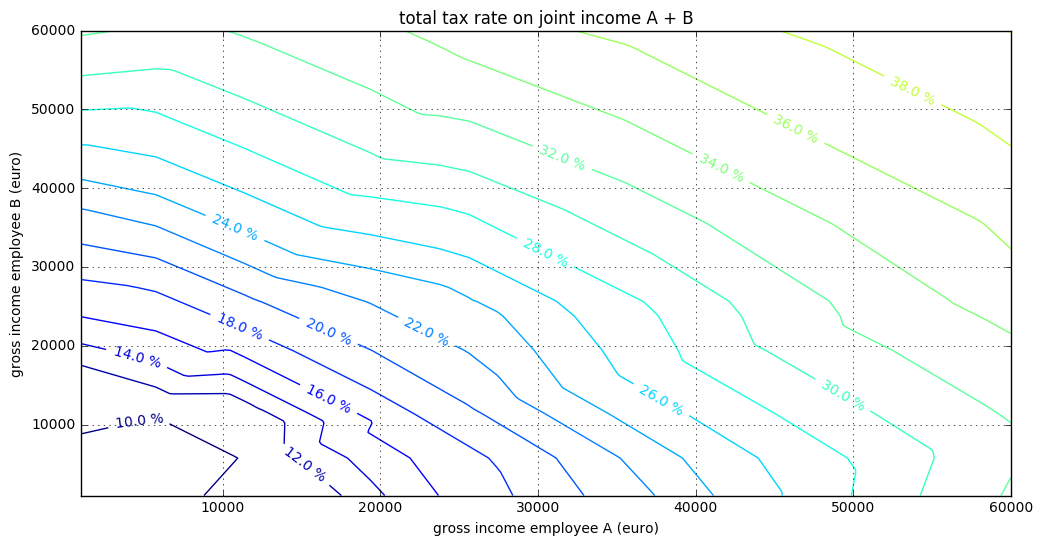

In [16]:
gross_income_a, gross_income_b = np.meshgrid(np.linspace(1e3, 6e4, 200), np.linspace(1e3, 6e4, 200))
tax_a, tax_b = income_tax_legally_cohabiting(gross_income_a, gross_income_b)
total_tax_rate = (tax_a + tax_b) / (gross_income_a + gross_income_b)
plot_tax_rate(gross_income_a, gross_income_b, total_tax_rate, 'total tax rate on joint income A + B')

## 3.4 Situation: individual self-employed + no dependents

In [17]:
static_parameters = {
    'legally_cohabiting': False,
    'n_dependents': 0,
    'municipality_tax': 0.07,
    'n_selfemployed': 1
}

In [18]:
income_tax_legally_cohabiting(np.array([3e4]), np.array([0.]))

(array([ 9149.24499309]), array([ 0.]))

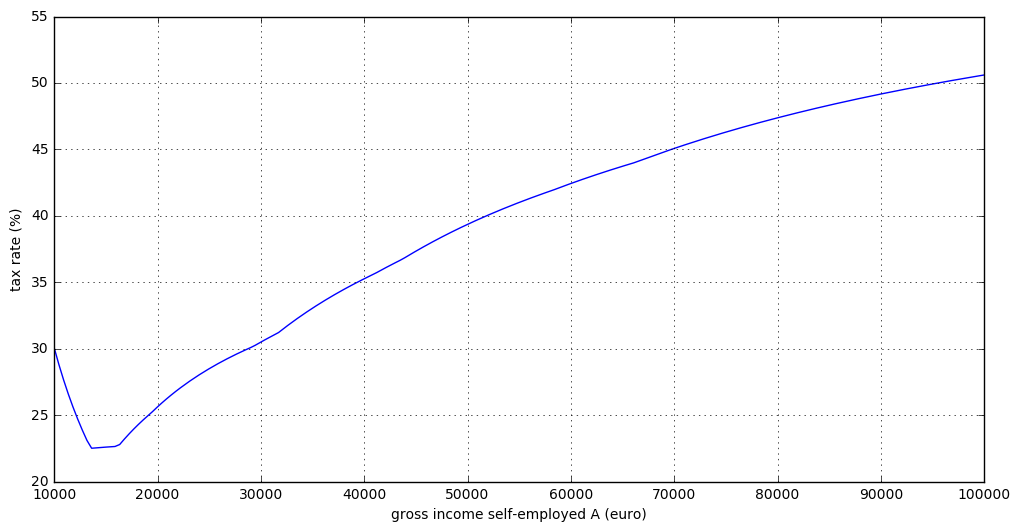

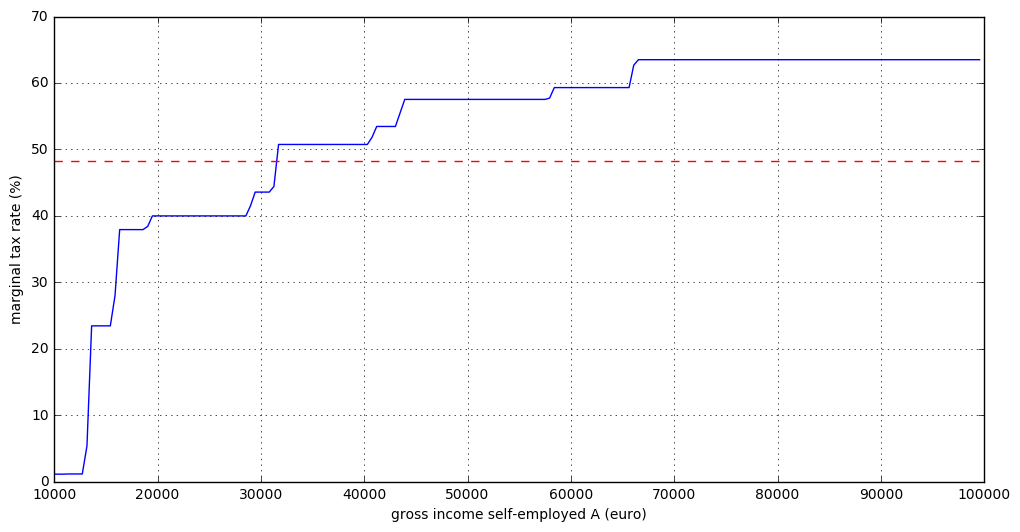

In [19]:
gross_income_a = np.linspace(1e4, 1e5, 200)
gross_income_b = np.zeros_like(gross_income_a)
tax_a, tax_b = income_tax_legally_cohabiting(gross_income_a, gross_income_b)
assert np.all(tax_b == 0.)

tax_rate = 100. * tax_a / gross_income_a
plt.figure(figsize=(12, 6))
plt.plot(gross_income_a, tax_rate)
plt.xlabel('gross income self-employed A (euro)')
plt.ylabel('tax rate (%)')
plt.grid(which='both')

marginal_tax_rate = np.diff(tax_rate * gross_income_a) / np.diff(gross_income_a)
plt.figure(figsize=(12, 6))
plt.plot(gross_income_a[:-1], marginal_tax_rate)
plt.axhline(y=100. * profit_extraction_tax, color='r', linestyle='--')
plt.xlabel('gross income self-employed A (euro)')
plt.ylabel('marginal tax rate (%)')
plt.grid(which='both')

In [20]:
tipping_point = 40e3
gross_monthly_salary = tipping_point / 12
net_monthly_salary = (1 - 0.35) * gross_monthly_salary
gross_monthly_salary, net_monthly_salary

(3333.3333333333335, 2166.666666666667)

## 3.5 Situation comparison: legally cohabiting full-time employee + (no employee vs. half-time employee vs. 4/5 vs. full-time) + one dependent

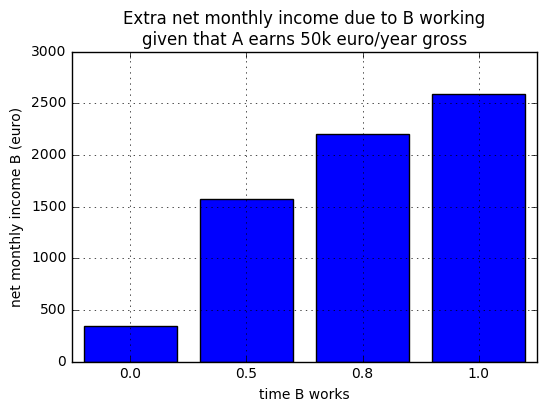

In [21]:
static_parameters = {
    'legally_cohabiting': True,
    'n_dependents': 1,
    'municipality_tax': 0.07,
    'n_selfemployed': 0
}
income_multipliers_B = np.array([0., 1./2., 4./5., 1.])
gross_income_A = 50e3 * np.ones_like(income_multipliers_B)
gross_income_B = income_multipliers_B * gross_income_A
taxes = np.zeros_like(income_multipliers_B)
for i, multiplier in enumerate(income_multipliers_B):
    taxes[i] = sum(income_tax_legally_cohabiting(np.array([gross_income_A[i]]), np.array([gross_income_B[i]])))
static_parameters['legally_cohabiting'] = False
taxes_A_without_B = sum(income_tax_legally_cohabiting(np.array([gross_income_A[0]]), np.array([0.])))
net_income_A_without_B = gross_income_A - taxes_A_without_B
net_income_B = (gross_income_A + gross_income_B - taxes) - net_income_A_without_B
plt.bar(np.arange(len(income_multipliers_B)), net_income_B / 12., align='center')
plt.xticks(np.arange(len(income_multipliers_B)), income_multipliers_B)
plt.grid()
plt.xlabel('time B works')
plt.ylabel('net monthly income B (euro)')
plt.title('Extra net monthly income due to B working\ngiven that A earns 50k euro/year gross');